# SPEI calculation using meteorological data

Using temperature and precipitation data from "Deutscher Wetterdienst" (DWD) (German weather service) which rely on the CRS **EPSG:31467**.\
The data is stored in ASCII files.

Unzip all `.asc.gz` files at once:\
`find . -type f -name "*.gz" -exec gunzip {} +`

### Function to create a plot

In [155]:
import numpy as np
import matplotlib.pyplot as plt
from config.colormap import SPEI_CMAP, SPEI_NORM


def spei_plot(file_path, title):
    # Read the header to get metadata information
    with open(file_path, 'r') as file:
        header = [next(file) for _ in range(6)]

    # Extract header values
    ncols = int(header[0].split()[1])
    nrows = int(header[1].split()[1])
    xllcorner = float(header[2].split()[1])
    yllcorner = float(header[3].split()[1])
    cellsize = float(header[4].split()[1])
    nodata_value = float(header[5].split()[1])

    # Load the data, skipping the header
    data = np.loadtxt(file_path, skiprows=6)

    # Handle NODATA values (e.g., replace them with NaN)
    data[data == nodata_value] = np.nan

    # Flip the data vertically to correct the orientation
    data = np.flipud(data)

    # Create a grid of x and y values
    x = np.arange(xllcorner, xllcorner + ncols * cellsize, cellsize)
    y = np.arange(yllcorner, yllcorner + nrows * cellsize, cellsize)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.imshow(data, cmap=SPEI_CMAP, aspect='auto', norm=SPEI_NORM, extent=[
            x.min(), x.max(), y.min(), y.max()], origin='lower')
    plt.colorbar(label='SPEI Value')
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

### Read the .asc files

In [48]:
import numpy as np
from datetime import datetime
from config.data_paths import EXT_STORAGE_DIR

In [49]:
def read_asc_file(filepath):
    """Reads an .asc file with a variable header size and returns the data as a numpy array."""
    header_keys = ['NCOLS', 'NROWS', 'XLLCORNER', 'YLLCORNER', 'CELLSIZE', 'NODATA_VALUE']
    header_info = {}

    with open(filepath, 'r') as file:
        line = file.readline()
        while line:
            parts = line.strip().split()
            if parts[0].upper() in header_keys:
                header_info[parts[0].lower()] = float(parts[1]) if parts[0].upper() != 'NCOLS' and parts[0].upper() != 'NROWS' else int(parts[1])
                if len(header_info) == len(header_keys):  # Break the loop if all necessary header info is collected
                    break
            line = file.readline()

        data = np.loadtxt(file, skiprows=0)  # No need to skip rows now, as the file pointer is already at the right position
        data[data == header_info['nodata_value']] = np.nan  # Convert NoData values to NaN
    
    return data, header_info

# Potential Evapotranspiration (PET) 

## Thornthwaite equation
Estimating the PET using the Thornthwaite equation which relys on the temperature and empirical constants.

In [50]:
# Example file name: grids_germany_monthly_air_temp_mean_202201.asc
# Example file name: grids_germany_monthly_precipitation_202201.asc
temp_save_dir = f"{EXT_STORAGE_DIR}/drought_data/temperature/dwd/avg"
prec_save_dir = f"{EXT_STORAGE_DIR}/drought_data/precipitation/dwd/avg"

temp_file_prefix = "grids_germany_monthly_air_temp_mean_"
prec_file_prefix = "grids_germany_monthly_precipitation_"

file_extension = ".asc"

In [51]:
dt = datetime(2022, 1, 1)
T_mean, header_info = read_asc_file(f"{temp_save_dir}/{temp_file_prefix}{dt.strftime('%Y%m')}{file_extension}")
prec_sum, _ = read_asc_file(f"{prec_save_dir}/{prec_file_prefix}{dt.strftime('%Y%m')}{file_extension}")

In [52]:
header_info

{'ncols': 654,
 'nrows': 866,
 'xllcorner': 3280414.711633467,
 'yllcorner': 5237500.62890625,
 'cellsize': 1000.0,
 'nodata_value': -999.0}

In [53]:
T_mean

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [54]:
prec_sum

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

### Calculate PET (Thornthwaite)

In [55]:
def estimate_pet_tw(temperature):
    """Estimates PET using the Thornthwaite equation."""
    # This is a simplified example; actual implementation may vary
    # depending on your exact needs and temperature input
    I = (temperature / 5.0) ** 1.514
    a = (6.75e-7 * I ** 3) - (7.71e-5 * I ** 2) + (1.792e-2 * I) + 0.49239
    PET = 16 * ((10 * temperature / I) ** a)
    return PET

In [56]:
pet_tw = estimate_pet_tw(T_mean)
pet_tw

/tmp/ipykernel_30956/2166093233.py:5: RuntimeWarning: invalid value encountered in power
  I = (temperature / 5.0) ** 1.514
/tmp/ipykernel_30956/2166093233.py:7: RuntimeWarning: invalid value encountered in divide
  PET = 16 * ((10 * temperature / I) ** a)


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [57]:
from scipy import stats

In [58]:
def calculate_spei(precipitation, pet, header_info):
    """Calculates SPEI on a basic level."""
    diff = precipitation - pet
    # Fit to a distribution, e.g., Pearson type III, Gamma, or others
    # This step is highly dependent on your dataset and needs
    params = stats.gamma.fit(diff[~np.isnan(diff)])  # Example with Gamma distribution
    # Calculate the cumulative distribution function (CDF) value for each difference
    cdf = stats.gamma.cdf(diff, *params)
    # Transform to the standard normal variable (z-score)
    spei = stats.norm.ppf(cdf)
    # Replace nan with NODATA_VALUE
    spei = np.where(np.isnan(spei), header_info['nodata_value'], spei) 
    return spei

In [59]:
spei_tw = calculate_spei(prec_sum, pet_tw, header_info)
spei_tw

array([[-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       ...,
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.]])

### Save SPEI values as .asc file (Thornthwaite)

In [60]:
def write_asc_file(data, filename, header_info):
    """Writes data to an .asc file using the provided header information."""
     
    try:
        with open(filename, 'w') as file:
            file.write(f"NCOLS {header_info['ncols']}\n")
            file.write(f"NROWS {header_info['nrows']}\n")
            file.write(f"XLLCORNER {header_info['xllcorner']}\n")
            file.write(f"YLLCORNER {header_info['yllcorner']}\n")
            file.write(f"CELLSIZE {header_info['cellsize']}\n")
            file.write(f"NODATA_VALUE {header_info['nodata_value']}\n")
            np.savetxt(file, data, fmt="%.4f")
            return True
    except Exception as e:
        print(f"Failed to save file '{filename}'. Exception: '{e}'")
        return False

In [61]:
spei_tw_save_path = f"output/spei_tw_{dt.strftime('%Y%m')}.asc"
write_asc_file(spei_tw, spei_tw_save_path, header_info)

True

### Plot the SPEI values (Thornthwaite)

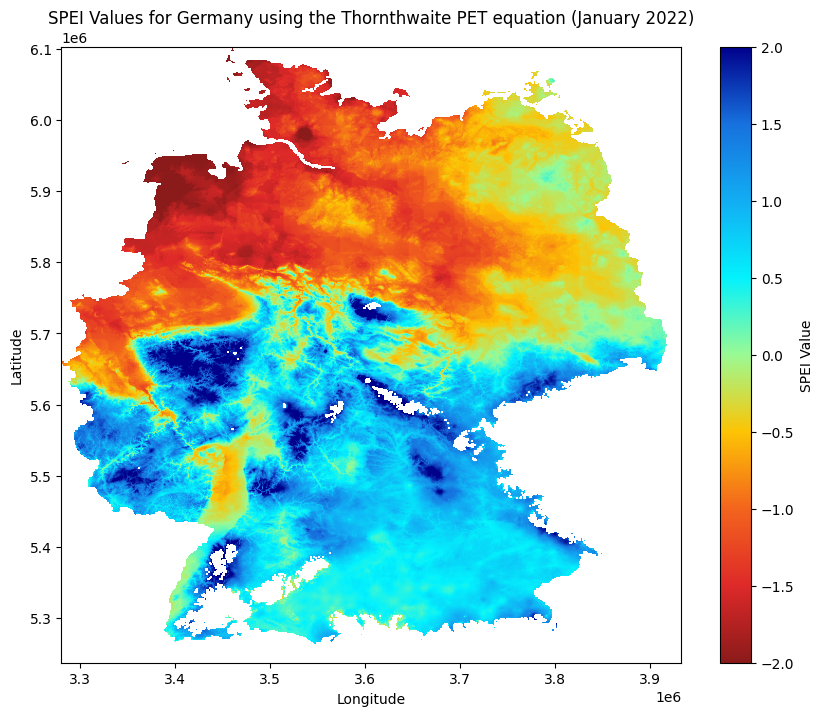

In [62]:
from matplotlib.colors import LinearSegmentedColormap, Normalize
import numpy as np
import matplotlib.pyplot as plt

# Path to ASCII file
spei_plot(spei_tw_save_path,
          f'SPEI Values for Germany using the Thornthwaite PET equation ({dt.strftime("%B %Y")})')

-----

## FAO-56-Penman-Monteith equation
Estimating the PET using the FAO-56-Penman-Monteith equation which relys on the temperature, humidity, wind speed, and solar radiation.

In [63]:
def estimate_svp(T):
    """Calculate the estimated saturation vapor pressure (in millibars) for a given temperature (in Celsius) using the Magnus formula."""
    return 6.112 * np.exp((17.67 * T) / (T + 243.5))
    # return 0.61078 * np.exp(17.269388 * (T) / (T - 35.86))

In [64]:
def estimate_net_radiation(Rs_kwh, T_max, T_min, es_mb):
    """
    Estimate net radiation using a simplified approach and saturation vapor pressure in millibars.
    
    Parameters:
    - Rs_kwh: Daily solar radiation in kWh/m^2.
    - T_max, T_min: Daily maximum and minimum temperatures in degrees Celsius.
    - es_mb: Saturation vapor pressure in millibars.
    
    Returns:
    - Rn: Net radiation in MJ/m^2/day.
    """
    # Constants
    sigma = 4.903e-9  # Stefan-Boltzmann constant (MJ K⁻⁴ m⁻² day⁻¹)
    albedo = 0.23  # Reflectivity of the surface, common value for grass
    
    # Convert solar radiation from kWh/m² to MJ/m⁻²/day⁻¹
    Rs = Rs_kwh * 3.6
    
    # Convert saturation vapor pressure from millibars to kPa
    es_kpa = es_mb * 0.1
    
    # Estimate net shortwave radiation
    Rns = (1 - albedo) * Rs
    
    # Estimate net longwave radiation using saturation vapor pressure as a proxy
    T_max_K = T_max + 273.15  # Convert to Kelvin
    T_min_K = T_min + 273.15  # Convert to Kelvin
    Rnl = sigma * ((T_max_K**4 + T_min_K**4) / 2) * (0.34 - 0.14 * np.sqrt(es_kpa)) * (1.35 * (Rs / (Rs_kwh * 3.6)) - 0.35)
    
    # Net radiation
    Rn = Rns - Rnl
    
    return Rn

In [65]:
def estimate_dew_point(T_min, T_max):
    """
    Enhanced approximation of the dew point using the maximum and minimum temperatures.
    This method assumes that the dew point is more accurately estimated by considering
    the daily temperature range.
    
    Parameters:
    - T_max: Maximum temperature in Celsius
    - T_min: Minimum temperature in Celsius
    """
    # Calculate the average daily range
    daily_range = T_max - T_min
    # Approximation coefficent
    adjustment_factor = 0.2  # TODO: get real value
    # Calculate the enhanced dew point estimate
    T_dew = T_min + adjustment_factor * daily_range
    return T_dew


In [66]:
def estimate_relative_humidity(T_min, T_max, T_mean):
    """
    Calculate the relative humidity using the Magnus formula and an approximation for the dew point.

    Parameters:
    - T_max: Maximum temperature in Celsius
    - T_mean: Mean temperature in Celsius
    - T_min: Minimum temperature in Celsius (used to approximate dew point)
    """
    # Approximate the dew point from the minimum temperature
    T_dew = estimate_dew_point(T_min, T_max)
    
    # Calculate saturation vapor pressure at the dew point and at the mean temperature
    E_s_dew = estimate_svp(T_dew)  # SVP at the dew point temperature
    E_s_mean = estimate_svp(T_mean)  # SVP at the mean air temperature
    
    # Calculate and return the relative humidity as a percentage
    RH = (E_s_dew / E_s_mean) * 100
    return RH

In [67]:
def estimate_pet_fao56pm(net_radiation, T_mean, RH, es_mb, u2=2.0, G=0, days_in_month=30.4583):
    """
    Estimate PET using the FAO-56 Penman-Monteith equation.
    
    Parameters:
    - Rn: Net radiation (MJ/m^2/day)
    - T_mean: Mean air temperature (°C)
    - RH: Relative Humidity (%)
    - es_mb: Saturation vapor pressure (millibars)
    - u2: Wind speed at 2m height (m/s), assuming an average if not provided
    
    Returns:
    - PET: Potential Evapotranspiration (mm/month)
    """
    # Constants
    # albedo = 0.23
    # sigma = 4.903e-9  # Stefan-Boltzmann constant (MJ/K^4/m^2/day)
    es_kpa = es_mb * 0.1  # Convert es from millibars to kPa
    ea_kpa = es_kpa * (RH / 100.0)  # Calculate actual vapor pressure

    # Rn: Net radiation
    Rn = (net_radiation * 3.6) #/ days_in_month
    
    # Calculate other required parameters
    delta_val = (4098 * (0.6108 * np.exp((17.27 * T_mean) / (T_mean + 237.3)))) / ((T_mean + 237.3) ** 2)  # Slope of vapor pressure curve
    gamma_val = 0.665 * 0.001 * 101.3  # Psychrometric constant, simplified assumption
    
    # FAO-56 Penman-Monteith equation
    PET = (0.408 * delta_val * (Rn - G) + gamma_val * (900 / (T_mean + 273)) * u2 * (es_kpa - ea_kpa)) / (delta_val + gamma_val * (1 + 0.34 * u2))
    
    # Replace nan with NODATA_VALUE
    PET = np.where(np.isnan(PET), header_info['nodata_value'], PET) 

    return PET


### Load additional datasets
The global radiation, min. temperature, max. temperature, relative humidity, the saturation vapor pressure and the net radiation are estimated using meteorological variables. 

In [68]:
global_radiation, _ = read_asc_file(f"{EXT_STORAGE_DIR}/drought_data/radiation/dwd/global/grids_germany_monthly_radiation_global_202201.asc")
T_min, _ = read_asc_file(f"{EXT_STORAGE_DIR}/drought_data/temperature/dwd/min/grids_germany_monthly_air_temp_min_202201.asc")
T_max, _ = read_asc_file(f"{EXT_STORAGE_DIR}/drought_data/temperature/dwd/max/grids_germany_monthly_air_temp_max_202201.asc")

rel_humidity = estimate_relative_humidity(T_min, T_max, T_mean)
svp = estimate_svp(T_mean)  # TODO: could also use T_min
net_radiation = estimate_net_radiation(Rs_kwh=global_radiation, T_max=T_max, T_min=T_min, es_mb=svp)

### Calculate PET (FAO-56-Penman-Monteith)

In [69]:
pet_fao56pm = estimate_pet_fao56pm(net_radiation=net_radiation, T_mean=T_mean, RH=rel_humidity, es_mb=svp, u2=2)
pet_fao56pm

array([[-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       ...,
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.]])

### Calculate SPEI (FAO-56-Penman-Monteith)

In [70]:
spei_fao56pm = calculate_spei(prec_sum, pet_fao56pm, header_info)
spei_fao56pm

array([[-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       ...,
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.]])

### Save SPEI values as .asc file (FAO-56-Penman-Monteith)

In [71]:
spei_fao56pm_save_path = f"output/spei_fao56pm_{dt.strftime('%Y%m')}.asc"
write_asc_file(spei_fao56pm, spei_fao56pm_save_path, header_info)

True

### Plot the SPEI values (FAO-56-Penman-Monteith)

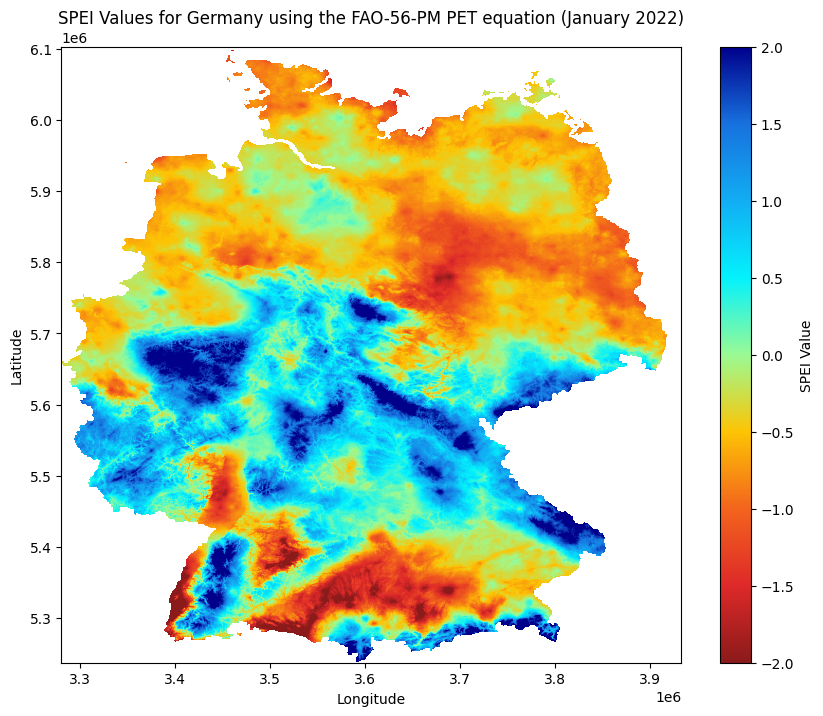

In [72]:
spei_plot(spei_fao56pm_save_path,
          f'SPEI Values for Germany using the FAO-56-PM PET equation ({dt.strftime("%B %Y")})')

----

## Difference between Thornthwaite and FAO-56-Penman-Monteith

In [73]:
diff_tw_pm = np.abs(spei_tw - spei_fao56pm)
write_asc_file(diff_tw_pm, f"output/diff_tw_pm_{dt.strftime('%Y%m')}.asc", header_info)

True

---

# Priestley-Taylor equation
The Priestley-Taylor equation relys on the net radiation and temperature. It is a simplified version of the FAO-56-Penman-Monteith equation.

In [74]:
def estimate_pet_pt(global_radiation, T_mean, G=0, gamma_val=0.066, alpha_val=1.26, days_in_month=30.4583,):
    """
    Estimate PET using the Priestley-Taylor equation.
    
    Parameters:
    - global_radiation: Global radiation sum (kWh/m²)
    - T_mean: Mean air temperature (°C)
    - days_in_month: Total days count of the to be analyzed month (average 30.4583)
    - G: Ground heat flux (MJ/m⁻²/day⁻¹) (usually 0)
    - gamma_val: Psychrometric constant (usually ~0.066)
    - alpha_val: Empirical constant factor (usually 1.26)
    
    Returns:
    - PET: Potential Evapotranspiration (mm/month) 
    """

    # Rn: Net radiation
    Rn = (global_radiation * 3.6) #/ days_in_month

    # Delta: Slope of vapor pressure curve
    delta_val = (4098 * (0.6108 * np.exp((17.27 * T_mean) / (T_mean + 237.3)))) / \
        ((T_mean + 237.3) ** 2) 

    # PET = alpha_val * (delta_val * (Rn - G) /
    #                    lambda_val * (delta_val + gamma_val))
    
    PET = alpha_val * (Rn - G) * (delta_val / delta_val + gamma_val)

    # Replace nan with NODATA_VALUE
    PET = np.where(np.isnan(PET), header_info['nodata_value'], PET)

    return PET

In [75]:
pet_pt = estimate_pet_pt(global_radiation=net_radiation, T_mean=T_mean)
pet_pt

array([[-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       ...,
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.]])

### Calculate SPEI (Priestley-Taylor)

In [76]:
spei_pt = calculate_spei(prec_sum, pet_pt, header_info)
spei_pt

array([[-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       ...,
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.]])

### Save SPEI values as .asc file (Priestley-Taylor)

In [77]:
spei_pt_save_path = f"output/spei_pt_{dt.strftime('%Y%m')}.asc"
write_asc_file(spei_pt, spei_pt_save_path, header_info)

True

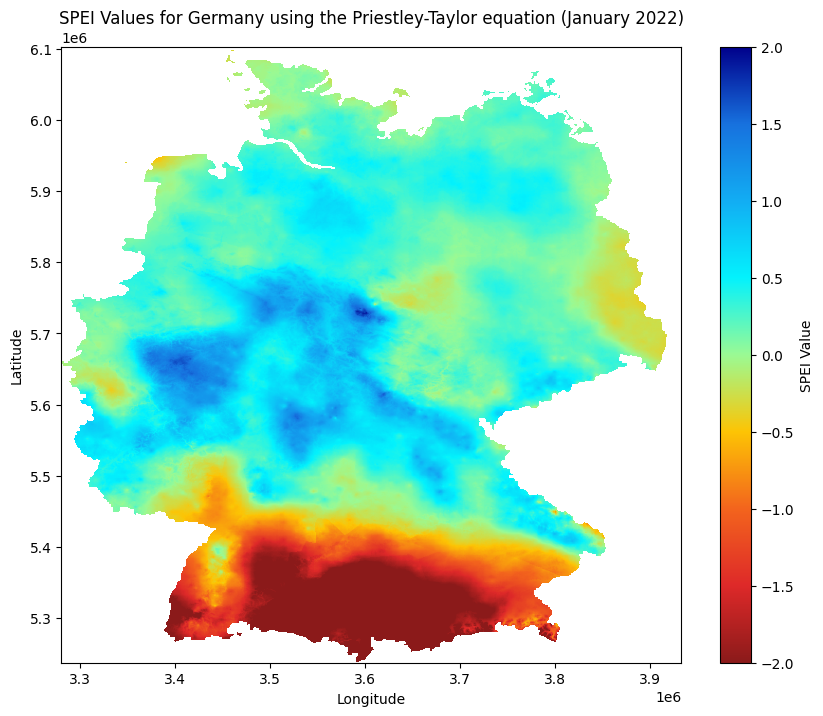

In [78]:
spei_plot(spei_pt_save_path,
          f'SPEI Values for Germany using the Priestley-Taylor equation ({dt.strftime("%B %Y")})')

## Difference between FAO 56 Penman-Monteith and Priestley-Taylor equation

In [79]:
diff_fao56pm_pt = np.abs(spei_fao56pm - spei_pt)
write_asc_file(diff_tw_pm, f"output/1diff_fa056pm_pt_{dt.strftime('%Y%m')}.asc", header_info)

/tmp/ipykernel_30956/57663131.py:1: RuntimeWarning: invalid value encountered in subtract
  diff_fao56pm_pt = np.abs(spei_fao56pm - spei_pt)


True

---

## Comparions to the SPEI Global Database

In [137]:
import numpy as np


def load_ascii_file(file_path):
    # Read the header to get metadata information
    with open(file_path, 'r') as file:
        header = [next(file) for _ in range(6)]

    # Extract header values
    # ncols = int(header[0].split()[1])
    # nrows = int(header[1].split()[1])
    # xllcorner = float(header[2].split()[1])
    # yllcorner = float(header[3].split()[1])
    # cellsize = float(header[4].split()[1])
    nodata_value = float(header[5].split()[1])

    # Load the data, skipping the header
    data = np.loadtxt(file_path, skiprows=6)

    # Handle NODATA values (e.g., replace them with NaN)
    data[data == nodata_value] = np.nan

    # Flip the data vertically to correct the orientation
    data = np.flipud(data)

    return data

In [138]:
import xarray as xr

def load_netcdf_file(file_path, year, month):

    data = xr.open_dataset(file_path)

    # Extract the region of Germany
    lat_min, lat_max =47.0, 55.0
    lon_min, lon_max = 5.5, 15.0
    spei_germany = data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max), time=f"{year}-{month}")

    # Close the netCDF file
    data.close()
    
    return spei_germany

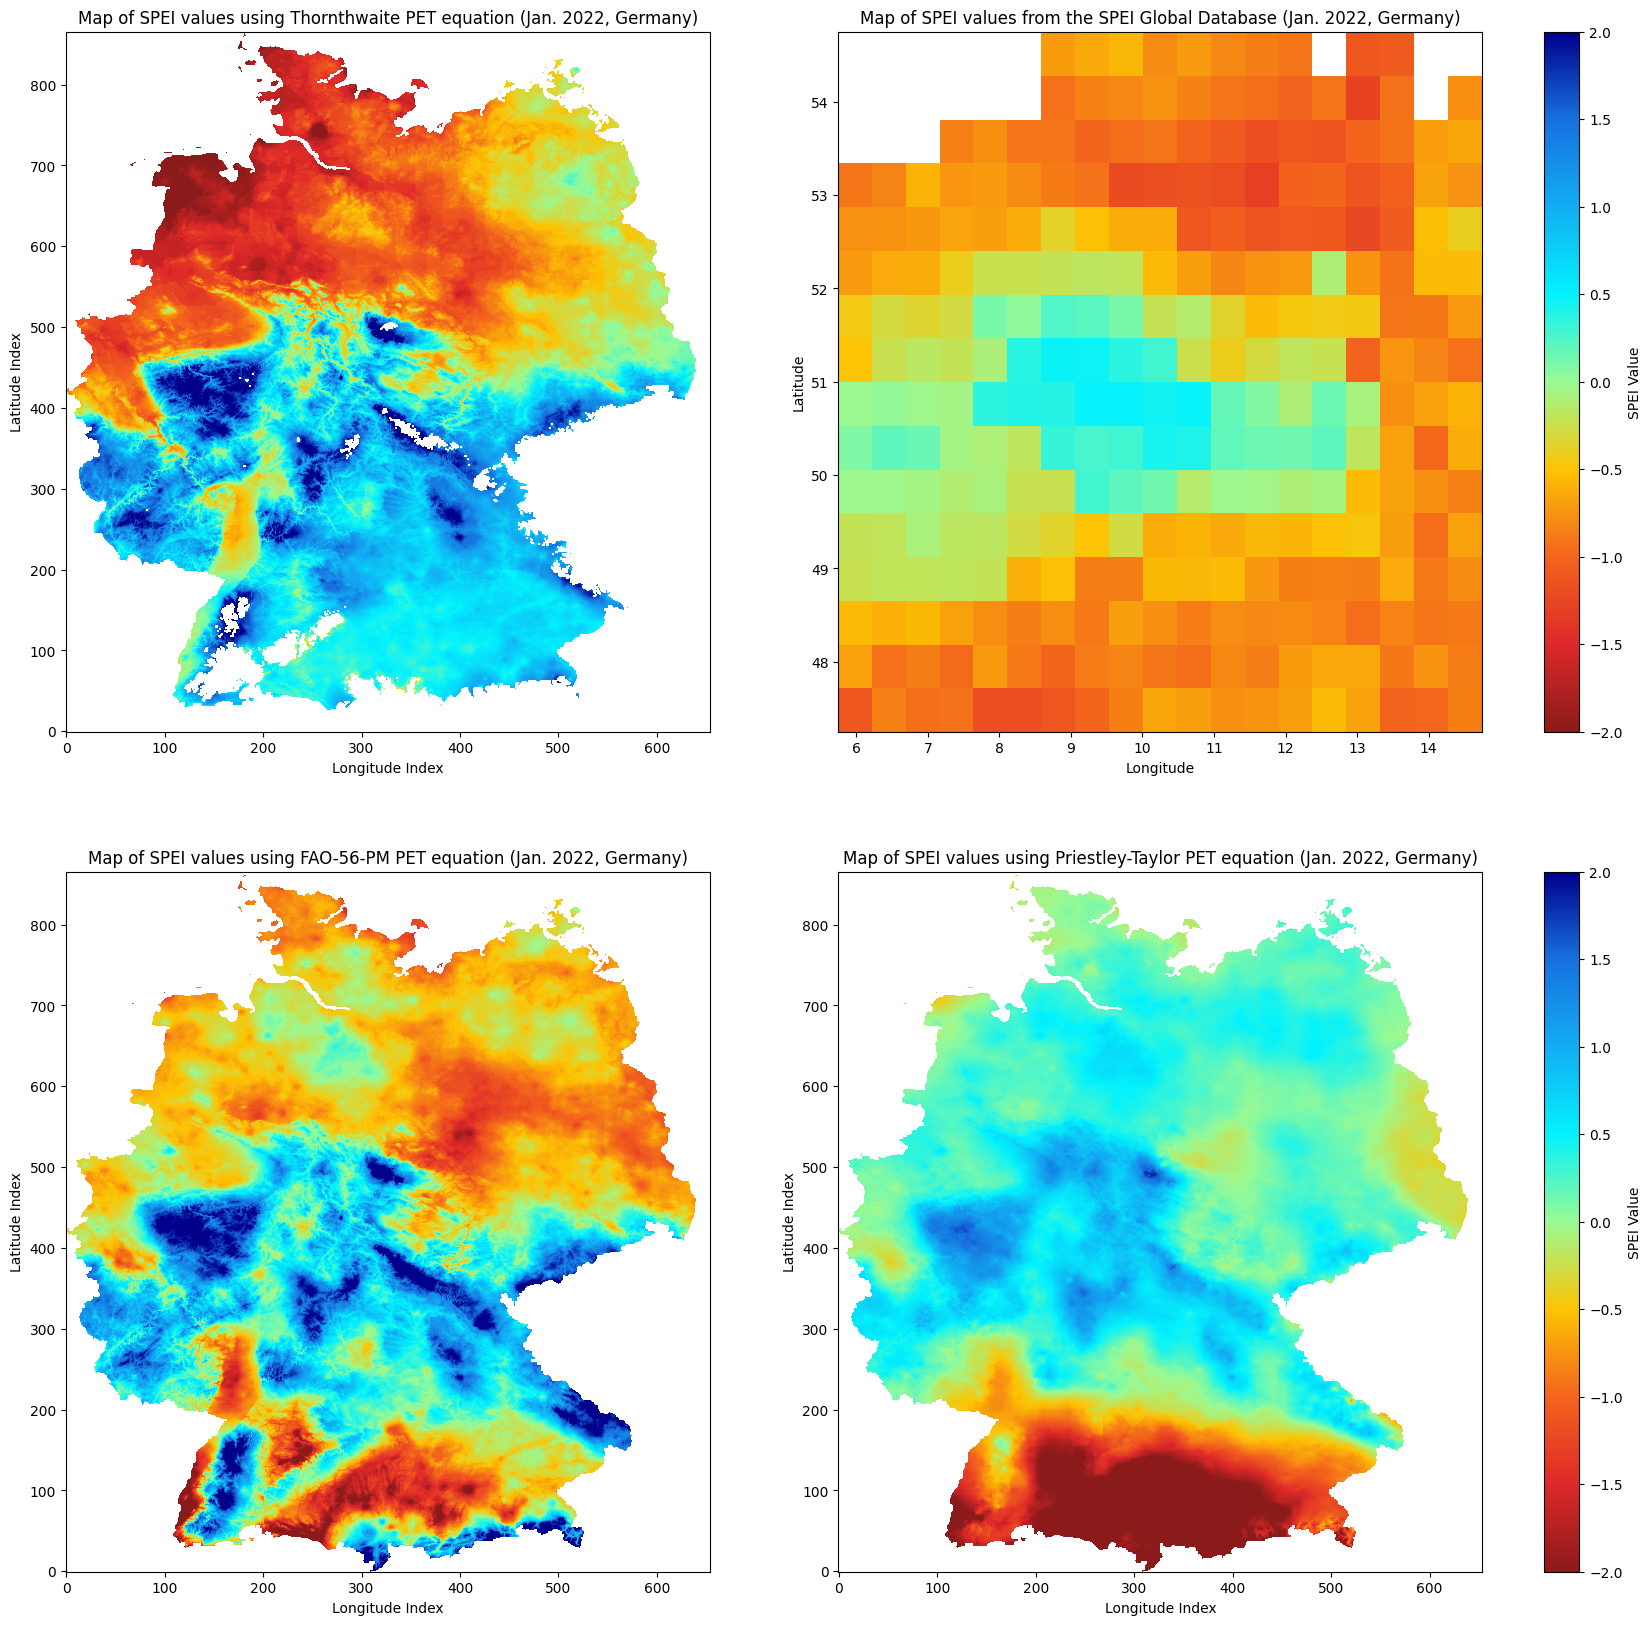

In [158]:
import matplotlib.pyplot as plt

# Paths to your files
# ascii_file_path = f'/media/jtrvz/chugchug/Git/drought-detector/methods/meteorological/output/spei_tw_{dt.strftime("%Y%m")}.asc'
netcdf_file_path = f'{EXT_STORAGE_DIR}/drought_data/spei/spei_db/spei_v2-9_19010116_20221216.nc'

# Load data
ascii_data_tw = load_ascii_file(spei_tw_save_path)
ascii_data_fao56pm = load_ascii_file(spei_fao56pm_save_path)
ascii_data_pt = load_ascii_file(spei_pt_save_path)
netcdf_data = load_netcdf_file(netcdf_file_path, dt.year, dt.month)

# Extract lat, lon, and SPEI values from the NetCDF data
lats = netcdf_data.lat.values
lons = netcdf_data.lon.values
spei_values = netcdf_data.spei.values.squeeze()

# Create plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

# Plot ASCII data
im1 = axes[0][0].imshow(ascii_data_tw, cmap=SPEI_CMAP, norm=SPEI_NORM, aspect='auto', origin='lower')
axes[0][0].set_title(f'Map of SPEI values using Thornthwaite PET equation ({dt.strftime("%b. %Y")}, Germany)')
axes[0][0].set_xlabel('Longitude Index')
axes[0][0].set_ylabel('Latitude Index')
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04, label='SPEI Value')

# Plot NetCDF data
im2 = axes[0][1].imshow(spei_values, cmap=SPEI_CMAP, norm=SPEI_NORM, aspect='auto', origin='lower',
                     extent=[lons.min(), lons.max(), lats.min(), lats.max()])
axes[0][1].set_title(
    f'Map of SPEI values from the SPEI Global Database ({dt.strftime("%b. %Y")}, Germany)')
axes[0][1].set_xlabel('Longitude')
axes[0][1].set_ylabel('Latitude')
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04, label='SPEI Value')

im3 = axes[1][0].imshow(ascii_data_fao56pm, cmap=SPEI_CMAP, norm=SPEI_NORM, aspect='auto', origin='lower')
axes[1][0].set_title(
    f'Map of SPEI values using FAO-56-PM PET equation ({dt.strftime("%b. %Y")}, Germany)')
axes[1][0].set_xlabel('Longitude Index')
axes[1][0].set_ylabel('Latitude Index')

im4 = axes[1][1].imshow(ascii_data_pt, cmap=SPEI_CMAP, norm=SPEI_NORM, aspect='auto', origin='lower')
axes[1][1].set_title(
    f'Map of SPEI values using Priestley-Taylor PET equation ({dt.strftime("%b. %Y")}, Germany)')
axes[1][1].set_xlabel('Longitude Index')
axes[1][1].set_ylabel('Latitude Index')

# plt.tight_layout()
plt.show()

The SPEI Global Database has been created by the inventors of the SPEI which is why is is used as a reference to compare the results of the calculated SPEI values using meteorological data.

As you can visually see is is though to compare the results between meteorological data and the SPEI Global Database because the SPEI map using the meteorological data is very high resolution while the dataset from the SPEI Global Database is very low resolution.

Nevertheless you can already see that the equations have different results and about none of the results using different PET equations can be said that it comes close to the SPEI Global Database.